In [13]:
import numpy as np
import healpy as hp
from healpy import projview
import emcee
from tqdm import tqdm
import matplotlib.pyplot as plt
import pyccl as ccl
import pandas as pd
from astropy.coordinates import SkyCoord
import os

# ==============================================
# 1. LEITURA E PREPARAÇÃO DOS DADOS OBSERVACIONAIS
# ==============================================

# Parâmetros fixos
H0 = 67.27  # Valor fixo do Hubble
h = H0 / 100
Omega_b = 0.0494
sigma8 = 0.8120
n_s = 0.9646

# Carregar o catálogo Pantheon+
data = pd.read_csv('/home/sofia/Documentos/Pantheon/Pantheon+SH0ES.csv', sep=' ')
cove = np.genfromtxt('/home/sofia/Documentos/Pantheon/Pantheon+SH0ES_STAT+SYS.cov', skip_header=1)
full_cov = np.reshape(cove, (1701, 1701))

# Adicionar índice às supernovas
data['index'] = np.arange(len(data))

# Filtrar por redshift (exemplo: 0.1 < z < 1.0)
z_min, z_max = 0.15, 0.5
data_filtered = data[(data['zCMB'] >= z_min) & (data['zCMB'] <= z_max)]

In [14]:
# ==============================================
# 2. DIVISÃO EM PIXELS HEALPix (nside=2)
# ==============================================

nside = 2  
npix = hp.nside2npix(nside)
raio = 90  # graus

# Obter coordenadas dos centros dos pixels
lon, lat = hp.pix2ang(nside, range(npix), lonlat=True)
galactic_coords = SkyCoord(l=lon, b=lat, frame='galactic', unit='deg')
equatorial_coords = galactic_coords.icrs
ra_pixel = equatorial_coords.ra.deg
dec_pixel = equatorial_coords.dec.deg

# Criar diretório para salvar os pixels
output_dir = '/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios_MCMC'  
os.makedirs(output_dir, exist_ok=True)

In [15]:
# ==============================================
# 3. ASSOCIAR SUPERNOVAS A CADA PIXEL
# ==============================================

# Converter coordenadas das supernovas para radianos
ra_data = np.radians(data_filtered['RA'].values)
dec_data = np.radians(data_filtered['DEC'].values)

# Para cada pixel, encontrar supernovas dentro do raio
pixel_data_list = []
for i in tqdm(range(npix), desc="Processando pixels"):
    # Coordenadas do centro do pixel
    ra_centro = np.radians(ra_pixel[i])
    dec_centro = np.radians(dec_pixel[i])
    
    # Fórmula de Haversine
    delta_ra = ra_data - ra_centro
    delta_dec = dec_data - dec_centro
    a = np.sin(delta_dec/2)**2 + np.cos(dec_centro)*np.cos(dec_data)*np.sin(delta_ra/2)**2
    distancia = np.degrees(2 * np.arcsin(np.sqrt(a)))
    
    # Selecionar supernovas dentro do raio
    mask = distancia <= raio
    pixel_data = data_filtered[mask].copy()
    
    # Salvar dados do pixel
    pixel_file = os.path.join(output_dir, f'pixel_{i:03d}.csv')
    pixel_data.to_csv(pixel_file, index=False)
    pixel_data_list.append(pixel_data)

Processando pixels: 100%|██████████| 48/48 [00:00<00:00, 56.10it/s]


In [16]:
# ==============================================
# FUNÇÕES AUXILIARES PARA O MCMC
# ==============================================

def log_prior(Omega_m):
    """Prior uniforme para Omega_m"""
    if 0.1 < Omega_m < 0.6:
        return 0.0
    return -np.inf

def log_likelihood(Omega_m, z, mu_obs, cov_inv):
    """Função de verossimilhança baseada nas distâncias modais"""
    # Parâmetros cosmológicos fixos
    H0 = 67.27
    h = H0 / 100
    Omega_b = 0.0494
    
    # Criar parâmetros cosmológicos para CCL
    cosmo = ccl.Cosmology(
        Omega_c=Omega_m - Omega_b,
        Omega_b=Omega_b,
        h=h,
        sigma8=0.8120,
        n_s=0.9646,
        transfer_function='eisenstein_hu',
        matter_power_spectrum='linear')
    
    # Calcular distância modais teóricas
    a = 1 / (1 + z)
    mu_theo = ccl.distance_modulus(cosmo, a)
    
    # Calcular chi^2
    delta = mu_obs - mu_theo
    chi2 = np.dot(delta, np.dot(cov_inv, delta))
    
    return -0.5 * chi2

def log_probability(Omega_m, z, mu_obs, cov_inv):
    """Probabilidade logarítmica total"""
    lp = log_prior(Omega_m)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(Omega_m, z, mu_obs, cov_inv)

def run_mcmc(z, mu_obs, cov_inv, nwalkers=10, nsteps=1000):
    """Executa o MCMC para estimar Omega_m"""
    # Inicializar walkers próximos a um valor razoável
    pos = np.random.uniform(0.2, 0.4, size=(nwalkers, 1))
    
    # Criar sampler
    sampler = emcee.EnsembleSampler(
        nwalkers, 1, log_probability,
        args=(z, mu_obs, cov_inv))
    
    # Executar MCMC
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    # Extrair amostras
    samples = sampler.get_chain(flat=True)
    
    return samples

In [17]:
# ==============================================
# PROCESSAMENTO DOS PIXELS COM DEBUG
# ==============================================

print(f"\nIniciando análise de {npix} pixels...")

Omega_m_values = np.full(npix, np.nan)
Omega_m_errors = np.full(npix, np.nan)

for i in tqdm(range(npix), desc="Analisando pixels"):
    pixel_file = os.path.join(output_dir, f'pixel_{i:03d}.csv')
    
    # Verificação do arquivo
    if not os.path.exists(pixel_file):
        print(f"\nPixel {i}: Arquivo não encontrado - {pixel_file}")
        continue
        
    if os.path.getsize(pixel_file) == 0:
        print(f"\nPixel {i}: Arquivo vazio - {pixel_file}")
        continue
    
    pixel_data = pd.read_csv(pixel_file)
    n_sne = len(pixel_data)
    
    # Verificação do número de supernovas
    if n_sne < 5:
        print(f"\nPixel {i}: Apenas {n_sne} supernovas (mínimo 5 requeridas)")
        continue
    
    # Extração de dados
    z = pixel_data['zCMB'].values
    mu_obs = pixel_data['MU_SH0ES'].values
    mu_err = pixel_data['MU_ERR'].values
    
    print(f"\nPixel {i} - Análise:")
    print(f"• Número de supernovas: {n_sne}")
    print(f"• z range: {np.min(z):.3f} - {np.max(z):.3f}")
    print(f"• μ range: {np.min(mu_obs):.3f} - {np.max(mu_obs):.3f}")
    print(f"• μ errors: {np.min(mu_err):.3f} - {np.max(mu_err):.3f}")
    
    # Verificação de valores inválidos
    if np.any(~np.isfinite(z)) or np.any(~np.isfinite(mu_obs)) or np.any(~np.isfinite(mu_err)):
        print("! Dados inválidos encontrados (NaN/Inf)")
        print(f"z has NaN: {np.any(np.isnan(z))}")
        print(f"μ has NaN: {np.any(np.isnan(mu_obs))}")
        print(f"μ errors has NaN: {np.any(np.isnan(mu_err))}")
        continue
    
    # Matriz de covariância (simplificada)
    cov_stat = np.diag(mu_err**2)
    
    try:
        cov_inv = np.linalg.inv(cov_stat)
    except np.linalg.LinAlgError:
        print("! Matriz de covariância singular - usando pseudoinversa")
        cov_inv = np.linalg.pinv(cov_stat)
    
    # Debug da matriz
    print(f"• Condição da matriz: {np.linalg.cond(cov_stat):.1e}")
    
    # Execução do MCMC
    try:
        samples = run_mcmc(z, mu_obs, cov_inv, nwalkers=10, nsteps=500)
        
        # Análise das amostras
        print(f"• Ωₘ estimado: {np.mean(samples):.3f} ± {np.std(samples):.3f}")
        print(f"• Aceitação: {np.mean(sampler.acceptance_fraction):.2f}")
        
        Omega_m_values[i] = np.mean(samples)
        Omega_m_errors[i] = np.std(samples)
        
    except Exception as e:
        print(f"! Erro no MCMC: {str(e)}")
        continue

# Pós-processamento para o plot
print("\nResumo dos resultados:")
print(f"Pixels com dados válidos: {np.sum(~np.isnan(Omega_m_values))}/{npix}")
print(f"Ωₘ global: {np.nanmean(Omega_m_values):.3f} ± {np.nanstd(Omega_m_values):.3f}")

# Substituição definitiva de NaN
Omega_m_values[~np.isfinite(Omega_m_values)] = -1  # Valor sentinela


Iniciando análise de 48 pixels...


Analisando pixels:   0%|          | 0/48 [00:00<?, ?it/s]


KeyError: 'MU_ERR'

/tmp/ipykernel_14980/306359062.py:9: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(Omega_m_values)  # Mínimo ignorando NaN
/tmp/ipykernel_14980/306359062.py:10: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(Omega_m_values)  # Máximo ignorando NaN


ValueError: Axis limits cannot be NaN or Inf

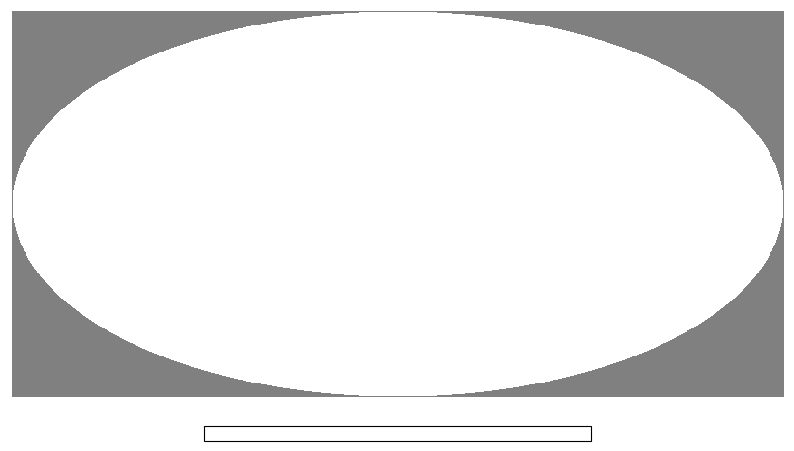

In [8]:
# ==============================================
# PLOT DO MAPA MOLLWEIDE (CORRIGIDO)
# ==============================================

# Substituir NaN por um valor fora do intervalo (ex.: -1)
Omega_m_values_filled = np.nan_to_num(Omega_m_values, nan=-1.0)  # NaN → -1

# Definir limites manualmente (evitando NaN/Inf)
vmin = np.nanmin(Omega_m_values)  # Mínimo ignorando NaN
vmax = np.nanmax(Omega_m_values)  # Máximo ignorando NaN

# Criar figura
plt.figure(figsize=(10, 7))

# Plotar mapa Mollweide
hp.mollview(
    Omega_m_values_filled,  # Usar array sem NaN
    coord=['C'],
    title=r"$\Omega_m$ por pixel (nside=2)",
    unit=r"$\Omega_m$",
    min=vmin,  # Definir limites manualmente
    max=vmax,
    cmap='viridis',
    hold=True)

# Adicionar grade
hp.graticule()

# Adicionar barra de cores
plt.colorbar(label=r"$\Omega_m$", orientation="horizontal")

# Salvar figura
plt.savefig(os.path.join(output_dir, 'omega_m_mollweide.png'), dpi=300, bbox_inches='tight')
plt.close()


In [ ]:

# ==============================================
# SALVAR RESULTADOS
# ==============================================

results = pd.DataFrame({
    'pixel': np.arange(npix),
    'ra_center': ra_pixel,
    'dec_center': dec_pixel,
    'Omega_m': Omega_m_values,
    'Omega_m_error': Omega_m_errors,
    'n_sne': [len(pd.read_csv(os.path.join(output_dir, f'pixel_{i:03d}.csv'))) if os.path.exists(os.path.join(output_dir, f'pixel_{i:03d}.csv')) else 0 for i in range(npix)]
})

results.to_csv(os.path.join(output_dir, 'omega_m_results.csv'), index=False)

print("Análise concluída! Resultados salvos em:", output_dir)